# Compare ROMS with ARGO profiler data


In [1]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask_jobqueue import SLURMCluster

In [2]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(48)
client

Client Scheduler: tcp://146.118.38.44:33666 Dashboard: http://146.118.38.44:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from datetime import datetime
from scipy.interpolate import PchipInterpolator

from glob import glob
from matplotlib import rcParams
from sfoda.roms.romsio import  get_depth
from sfoda.utils.inpolygon import inpolygon

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "12"
rcParams['axes.labelsize']='medium'



Warning - could not import octant package.


In [4]:
# Standard ARGO variable names
timevar = 'JULD'
xvar = 'LONGITUDE'
yvar = 'LATITUDE'
zvar = 'PRES_ADJUSTED'
zvar_qc = 'PRES_ADJUSTED_QC'
tvar = 'TEMP_ADJUSTED'
tvar_qc = 'TEMP_ADJUSTED_QC'

def load_argo_T(argofile, zout, tvar='TEMP_ADJUSTED', outvar='watertemp'):
    ds = xr.open_dataset(argofile)
    z = ds[zvar].values[0,:].squeeze()
    T = ds[tvar].values[0,:].squeeze()
    #zu, idx = np.unique(z, return_index=True)
    #Tu = T[idx]
    idx = (~np.isnan(z)) & (~np.isnan(T))
    zu = z[idx]
    Tu = T[idx]
    #print(Tu, zu)
    #print(argofile, z.shape, Tu.shape, T.shape, zu.shape)

    T_da = xr.DataArray(Tu, coords={'pressure':zu}, dims=('pressure',), attrs=ds[tvar].attrs)
    ds_out = xr.Dataset({outvar:T_da, xvar:ds[xvar],yvar:ds[yvar], timevar:ds[timevar]})
    #print(T_da.interp({'pressure':zout}))
    if ds_out['pressure'].shape[0] == 0:
        return None
    
    return ds_out.interp({'pressure':zout})

In [5]:
argofiles = glob('../ObsData/*.nc')


In [6]:
# load_argo_T('../ObsData/D5901680_306.nc',zout)

In [7]:
# Look at an argo file
ds = xr.open_dataset(argofiles[0])

# Use the depths from the first file as the standard depths
zout = ds[zvar].values.squeeze()

zout

array([   4.2,    9. ,   14.4,   19.2,   24.3,   29.3,   34.4,   39.6,
         44.5,   49.4,   54.9,   59.6,   69.7,   79.4,   89.6,   99.6,
        109.6,  119.4,  129.4,  139.6,  149.6,  159.4,  169.3,  179.3,
        189.7,  199.4,  209.4,  219.3,  229.1,  239. ,  249. ,  259.2,
        269.6,  279.4,  299.2,  319.5,  339.2,  359.2,  378.9,  399.2,
        419.2,  439. ,  459.3,  478.8,  499.2,  549.4,  598.9,  649.4,
        699.1,  749.2,  799. ,  849.1,  899.5,  949. ,  999.3, 1049.4,
       1099.2, 1149.3, 1198.9, 1249.2, 1299.5, 1348.9, 1399.1, 1449. ,
       1499.3, 1599.3, 1699. , 1799.1, 1899.2, 1986.8], dtype=float32)

In [8]:
# Stack them all together
T = xr.concat([load_argo_T(argofile,zout) for argofile in argofiles] ,'N_PROF')

In [9]:
T

<xarray.Dataset>
Dimensions:    (N_PROF: 306, pressure: 70)
Coordinates:
  * pressure   (pressure) float32 4.2 9.0 14.4 19.2 ... 1799.1 1899.2 1986.8
Dimensions without coordinates: N_PROF
Data variables:
    watertemp  (N_PROF, pressure) float32 26.518 26.518 ... 2.5935001 2.4328942
    LONGITUDE  (N_PROF) float64 108.0 117.3 107.7 103.0 ... 116.3 120.6 117.2
    LATITUDE   (N_PROF) float64 -18.55 -13.83 -12.07 ... -14.73 -16.78 -14.91
    JULD       (N_PROF) datetime64[ns] 2017-05-08T22:33:59.000031232 ... 2017...

In [57]:
Sall = []
for argofile in argofiles:
    myS = load_argo_T(argofile,zout, tvar='PSAL_ADJUSTED', outvar='salinity')
    if myS is not None:
        Sall.append(myS)
S = xr.concat( Sall, 'N_PROF')
S

<xarray.Dataset>
Dimensions:    (N_PROF: 301, pressure: 70)
Coordinates:
  * pressure   (pressure) float32 4.2 9.0 14.4 19.2 ... 1799.1 1899.2 1986.8
Dimensions without coordinates: N_PROF
Data variables:
    salinity   (N_PROF, pressure) float32 34.587025 34.587025 ... 34.72522
    LONGITUDE  (N_PROF) float64 108.0 117.3 107.7 103.0 ... 116.3 120.6 117.2
    LATITUDE   (N_PROF) float64 -18.55 -13.83 -12.07 ... -14.73 -16.78 -14.91
    JULD       (N_PROF) datetime64[ns] 2017-05-08T22:33:59.000031232 ... 2017...

In [40]:
# Load a ROMS file
romsvar = 'salt'

## 4Dvar run
# romsfiles = glob('/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/archive_fwd2_*.nc')
# myroms = xr.open_mfdataset(romsfiles, concat_dim='ocean_time', parallel=True)
# outfile = '../DATA/ROMS_4DVar_ARGO_temp.nc'

## Standalone run

# myroms = xr.open_mfdataset('../ROMSdata/outputs/roms_nws_*his.nc', concat_dim='ocean_time', 
#                         parallel=True)
# outfile = '../DATA/ROMS_ARGO_temp.nc'

# romsfiles = '../ROMSdata/4DVAR/archive_fwd2_6*.nc'
# outfile = '../DATA/ROMS_4DVar_ARGO_{}_v2.nc'.format(romsvar)

romsfiles = '../ROMSdata/4DVAR/archive_fwd_ver_6*.nc'
outfile = '../DATA/ROMS_NLM_ARGO_{}_v2.nc'.format(romsvar)

myroms = xr.open_mfdataset(romsfiles,
                        concat_dim='ocean_time', 
                        parallel=True)


# DRop non-unique time variables
_, index = np.unique(myroms['ocean_time'], return_index=True)
roms =myroms[romsvar].isel(ocean_time=index).chunk({'ocean_time':1,'s_rho':-1, 'eta_rho':-1,'xi_rho':-1},)
roms

<xarray.DataArray 'salt' (ocean_time: 1441, s_rho: 30, eta_rho: 482, xi_rho: 1010)>
dask.array<rechunk-merge, shape=(1441, 30, 482, 1010), dtype=float32, chunksize=(1, 30, 482, 1010), chunktype=numpy.ndarray>
Coordinates:
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time  (ocean_time) datetime64[ns] 2017-02-01 ... 2017-06-01
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  salinity
    time:       ocean_time
    grid:       grid
    location:   face
    field:      salinity, scalar, series

In [41]:
myroms

<xarray.Dataset>
Dimensions:     (eta_rho: 482, eta_u: 482, eta_v: 481, ocean_time: 1470, s_rho: 30, xi_rho: 1010, xi_u: 1009, xi_v: 1010)
Coordinates:
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lat_v       (eta_v, xi_v) float64 dask.array<chunksize=(481, 1010), meta=np.ndarray>
    lon_u       (eta_u, xi_u) float64 dask.array<chunksize=(482, 1009), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lon_v       (eta_v, xi_v) float64 dask.array<chunksize=(481, 1010), meta=np.ndarray>
    lat_u       (eta_u, xi_u) float64 dask.array<chunksize=(482, 1009), meta=np.ndarray>
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time  (ocean_time) datetime64[ns] 2017-02-01 ... 2017-06-01
Dimensions without coordinates: eta_rho, eta_u, eta_v, xi_rho, xi_u, xi_v
Data variables:
    Cs_r        (ocean_time, s_rho) float64 dask.array<chunksize=(49, 30), meta=np.ndarray>
    h           (ocean_time, eta_rho, xi_rho) float64 dask.array<chunksize=(49, 482, 1010), meta=np.ndarray>
    hc          (ocean_time) float64 150.0 150.0 150.0 ... 150.0 150.0 150.0
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(49, 30, 482, 1010), meta=np.ndarray>
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(49, 30, 482, 1010), meta=np.ndarray>
    u           (ocean_time, s_rho, eta_u, xi_u) float32 dask.array<chunksize=(49, 30, 482, 1009), meta=np.ndarray>
    ubar        (ocean_time, eta_u, xi_u) float32 dask.array<chunksize=(49, 482, 1009), meta=np.ndarray>
    v           (ocean_time, s_rho, eta_v, xi_v) float32 dask.array<chunksize=(49, 30, 481, 1010), meta=np.ndarray>
    vbar        (ocean_time, eta_v, xi_v) float32 dask.array<chunksize=(49, 481, 1010), meta=np.ndarray>
    zeta        (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(49, 482, 1010), meta=np.ndarray>
Attributes:
    file:              ./outputs/his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             NWS VERIFICATION ROMS
    var_info:          varinfo.dat
    rst_file:          ./outputs/rst.nc
    his_file:          ./outputs/his.nc
    avg_file:          ./outputs/avg.nc
    sta_file:          ./outputs/sta.nc
    grd_file:          grid.nc
    ini_file:          ini.nc
    tide_file:         tide.nc
    frc_file_01:       forcing.nc
    clm_file_01:       bry.nc
    script_file:       ocean.in
    spos_file:         stations.in
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    NLM_LBC:           \nEDGE:  WEST   SOUTH  EAST   NORTH  \nzeta:  Cha    C...
    svn_url:           https://www.myroms.org/svn/src/trunk
    svn_rev:           1037
    code_dir:          /group/pawsey0219/ijanekovic/GIT/testing/trunk
    header_dir:        /group/pawsey0219/ijanekovic/NWS_ASSIM
    header_file:       nws_verification.h
    os:                Linux
    cpu:               x86_64
    compiler_system:   ftn
    compiler_command:  /opt/cray/pe/craype/2.5.13/bin/ftn
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3
    tiling:            024x010
    history:           Fri Oct 30 10:19:51 2020: ncks -7 --ppc default=.5 -vt...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       NWS_VERIFICATION, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, AN...
    NCO:               netCDF Operators version 4.7.6 (Homepage = http://nco....

In [42]:
# Function to find the nearest ROMS point
# grid = xr.open_dataset('/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/archive_fwd2_6241.nc')

grid=myroms
xroms = grid.lon_rho.values
yroms = grid.lat_rho.values



In [43]:
# Create a polyon
xpoly = [xroms[0,0], xroms[0,-1], xroms[-1,-1], xroms[-1,0], xroms[0,0]]
ypoly = [yroms[0,0], yroms[0,-1], yroms[-1,-1], yroms[-1,0], yroms[0,0]]
# idx = inpolygon(np.array([T[xvar].values, T[yvar].values]).T,np.array([xpoly,ypoly]).T)
idx = inpolygon(np.array([S[xvar].values, S[yvar].values]).T,np.array([xpoly,ypoly]).T)

idx

array([False,  True,  True, False, False, False, False,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True, False,
       False,  True,  True, False, False,  True,  True, False, False,
       False,  True,  True,  True,  True, False,  True,  True,  True,
       False, False,  True,  True,  True,  True, False, False, False,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False, False, False, False,  True,  True, False,  True, False,
       False,  True,  True,  True,  True, False,  True,  True, False,
       False,  True, False, False, False,  True,  True, False,  True,
       False,  True,  True,  True,  True, False, False,  True, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False,

In [44]:
@dask.delayed
def get_depth_delayed(s, Cs, hc, h):
    return get_depth(s, Cs, hc, h)

In [45]:
# Get the point
def get_roms(xpt, ypt, timept):
    dist = np.abs( (xpt-xroms) + 1j*(ypt-yroms))
    idx = np.argwhere(dist==dist.min())
    J,I = idx[0,0],idx[0,1]
    #temp = roms['temp'].isel(eta_rho=J, xi_rho=I).sel(ocean_time=timept, method='nearest')
    #temp = roms.sel(ocean_time=timept, method='nearest').isel(eta_rho=J, xi_rho=I)
    
    dt = (roms.ocean_time.values - timept ).astype(float)
    Tidx = np.argwhere(dt>0)
    if Tidx.shape[0] > 0:
        T =  np.argwhere(dt>0)[0]
    else:
        T = -1
        
    temp = roms.isel(ocean_time=T, eta_rho=J, xi_rho=I)
    
    #h = roms['h'].isel(eta_rho=J, xi_rho=I)
    #zroms = get_depth(temp.s_rho.values, roms.Cs_r.values[0,:], roms.hc.values[0], h)
    #zroms = get_depth_delayed(temp.s_rho, roms.Cs_r[0,:], roms.hc[0], h[0])

    return temp, J, I #,xr.DataArray(temp, coords={'depth':zroms}, dims=('depth',))



In [46]:
tempall = []
jj = []
ii = []
#for xpt, ypt, timept in zip(T[xvar].values[idx], T[yvar].values[idx], T[timevar].values[idx]):
for xpt, ypt, timept in zip(S[xvar].values[idx], S[yvar].values[idx], S[timevar].values[idx]):

    temp, J,I = get_roms(xpt, ypt, timept)
    tempall.append(temp)
    jj.append(J)
    ii.append(I)

In [47]:
ds = xr.concat(tempall, dim='ocean_time').compute()
#ds = xr.concat(tempall, dim='ocean_time').persist()

ds

<xarray.DataArray 'salt' (ocean_time: 152, s_rho: 30)>
array([[34.720444, 34.701744, 34.701897, ..., 34.810074, 34.6837  ,
        34.643784],
       [34.704964, 34.702133, 34.70262 , ..., 34.37252 , 34.37262 ,
        34.37285 ],
       [34.71421 , 34.710114, 34.702637, ..., 34.804146, 34.804153,
        34.808395],
       ...,
       [34.720627, 34.702316, 34.701706, ..., 34.801636, 34.769577,
        34.757202],
       [34.61789 , 34.62471 , 34.637367, ..., 34.926544, 34.926735,
        34.926987],
       [34.72029 , 34.702057, 34.702263, ..., 34.69957 , 34.806633,
        34.834946]], dtype=float32)
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lat_rho     (ocean_time) float64 -13.82 -12.05 -13.94 ... -16.77 -14.91
    lon_rho     (ocean_time) float64 117.3 107.7 121.3 ... 116.3 120.6 117.2
  * ocean_time  (ocean_time) datetime64[ns] 2017-04-18T18:00:00 ... 2017-03-2...
Attributes:
    long_name:  salinity
    time:       ocean_time
    grid:       grid
    location:   face
    field:      salinity, scalar, series

In [48]:
grid.Cs_r, grid.hc

(<xarray.DataArray 'Cs_r' (ocean_time: 1470, s_rho: 30)>
 dask.array<concatenate, shape=(1470, 30), dtype=float64, chunksize=(49, 30), chunktype=numpy.ndarray>
 Coordinates:
   * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
   * ocean_time  (ocean_time) datetime64[ns] 2017-02-01 ... 2017-06-01
 Attributes:
     long_name:  S-coordinate stretching curves at RHO-points
     valid_min:  -1.0
     valid_max:  0.0
     field:      Cs_r, scalar, <xarray.DataArray 'hc' (ocean_time: 1470)>
 array([150., 150., 150., ..., 150., 150., 150.])
 Coordinates:
   * ocean_time  (ocean_time) datetime64[ns] 2017-02-01 ... 2017-06-01
 Attributes:
     long_name:  S-coordinate parameter, critical depth
     units:      meter)

In [49]:
depths = grid['h'].isel(ocean_time=0)
Cs_r = grid['Cs_r'].isel(ocean_time=0)
hc = grid['hc'].isel(ocean_time=0)
hc

<xarray.DataArray 'hc' ()>
array(150.)
Coordinates:
    ocean_time  datetime64[ns] 2017-02-01
Attributes:
    long_name:  S-coordinate parameter, critical depth
    units:      meter

In [50]:
# Compute the depths
ctr=0
zromsall = []
hall = []
lon_rho =[]
lat_rho =[]

for J,I in zip(jj,ii):
    h = depths.isel(eta_rho=J, xi_rho=I)
    lon = xroms[J,I]#grid['lon_rho'].isel(eta_rho=J, xi_rho=I)
    lat = yroms[J,I]#grid['lat_rho'].isel(eta_rho=J, xi_rho=I)

    #zroms = get_depth(temp.s_rho.values, roms.Cs_r.values[0,:], roms.hc.values[0], h)
    zroms = get_depth_delayed(temp.s_rho, Cs_r, hc, h)
    zromsall.append(zroms)
    hall.append(h)
    lon_rho.append(lon)
    lat_rho.append(lat)
    
zromsall = dask.compute(*zromsall)
Z = np.array(zromsall)

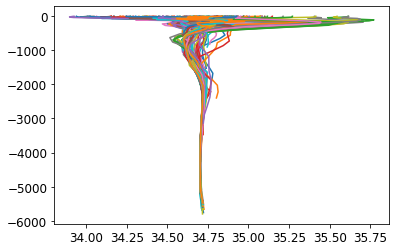

In [51]:
for ii in range(152):
    plt.plot( ds[ii,:], Z[ii,:])

In [52]:
# Loop through and interpolate all of the temperature onto ARGO depths
nx, nz = Z.shape
nzout = zout.shape[0]
Troms_i = np.zeros((nx,nzout))
for ii in range(nx):
    F = PchipInterpolator(Z[ii,:], ds[ii,:],extrapolate=False) # Return NaNs when out of bounds
    Troms_i[ii,:] = F(-zout)

In [53]:
# Tobs_ds = T.isel(N_PROF=idx)
Tobs_ds = S.isel(N_PROF=idx)

Tobs_ds

<xarray.Dataset>
Dimensions:    (N_PROF: 152, pressure: 70)
Coordinates:
  * pressure   (pressure) float32 4.2 9.0 14.4 19.2 ... 1799.1 1899.2 1986.8
Dimensions without coordinates: N_PROF
Data variables:
    salinity   (N_PROF, pressure) float32 nan 34.34294 ... 34.719925 34.72522
    LONGITUDE  (N_PROF) float64 117.3 107.7 121.3 117.9 ... 116.3 120.6 117.2
    LATITUDE   (N_PROF) float64 -13.83 -12.07 -13.94 ... -14.73 -16.78 -14.91
    JULD       (N_PROF) datetime64[ns] 2017-04-18T16:46:39.000012800 ... 2017...

In [54]:
# Output the interpolated ROMS into the same format
T_da = xr.DataArray(Troms_i, coords={'pressure':zout},\
                dims=('N_PROF','pressure',), attrs=roms.attrs)
lon_ds = xr.DataArray(lon_rho,dims=('N_PROF',))
lat_ds = xr.DataArray(lat_rho,dims=('N_PROF',))
Tmod_ds = xr.Dataset({'salinity':T_da, xvar:lon_ds,yvar:lat_ds, timevar:ds['ocean_time'].values})
# Tmod_ds = xr.Dataset({'watertemp':T_da, xvar:lon_ds,yvar:lat_ds, timevar:ds['ocean_time'].values})
Tmod_ds

<xarray.Dataset>
Dimensions:    (JULD: 152, N_PROF: 152, pressure: 70)
Coordinates:
  * pressure   (pressure) float32 4.2 9.0 14.4 19.2 ... 1799.1 1899.2 1986.8
  * JULD       (JULD) datetime64[ns] 2017-04-18T18:00:00 ... 2017-03-20T08:00:00
Dimensions without coordinates: N_PROF
Data variables:
    salinity   (N_PROF, pressure) float64 34.65 34.68 34.73 ... 34.7 34.71 34.72
    LONGITUDE  (N_PROF) float64 117.3 107.7 121.3 117.9 ... 116.3 120.6 117.2
    LATITUDE   (N_PROF) float64 -13.82 -12.05 -13.94 ... -14.72 -16.77 -14.91

In [55]:
# outfile = '../DATA/ARGO_gridded_salt.nc'
Tmod_ds.to_netcdf(outfile)
print(outfile)


../DATA/ROMS_NLM_ARGO_salt_v2.nc


In [59]:
Tobs_ds.to_netcdf('../DATA/ARGO_gridded_salt.nc')
Tobs_ds

<xarray.Dataset>
Dimensions:    (N_PROF: 152, pressure: 70)
Coordinates:
  * pressure   (pressure) float32 4.2 9.0 14.4 19.2 ... 1799.1 1899.2 1986.8
Dimensions without coordinates: N_PROF
Data variables:
    salinity   (N_PROF, pressure) float32 nan 34.34294 ... 34.719925 34.72522
    LONGITUDE  (N_PROF) float64 117.3 107.7 121.3 117.9 ... 116.3 120.6 117.2
    LATITUDE   (N_PROF) float64 -13.83 -12.07 -13.94 ... -14.73 -16.78 -14.91
    JULD       (N_PROF) datetime64[ns] 2017-04-18T16:46:39.000012800 ... 2017...

In [58]:
S=argo.isel('N_PROF'=idx)

SyntaxError: keyword can't be an expression (<ipython-input-58-011bfe1034f7>, line 1)